<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import f1_score, jaccard_score, accuracy_score, confusion_matrix, classification_report
import random
from sklearn import svm
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%matplotlib inline

# About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets plot some columns to underestand data better:

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## Preprocessing

I want to first do my own preprocessing to do a train test split and make one-hot encoding. That way, it's not such a blackbox

In [2]:
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error, accuracy_score, log_loss

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks([0,1], classes, rotation=45)
    plt.yticks([0,1], classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        i_i = i
        if i == 1:
            i_i=0.75
        if i == 0:
            i_i = 0.25
        plt.text(j, i_i, format(cm[i, j], fmt),
                 horizontalalignment="center",verticalalignment='center',size=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def train_test_split_pandas(df, x_cols=[],y_cols=[], test=0.2):
    '''
    split dataframe into train_test, 
    
    if no x_cols or y_col is supplied, then the dataframe will just be split into train_test df
    
    if x_cols and y_cols is supplied it will return 4 arrays, train_x, test_x, train_y, test_y
    
    '''
    train_df = df.sample(int((1-test)*len(df)))
    test_df = df[~df.index.isin(train_df.index)]
    if not x_cols:
        return train_df, test_df

    else:
        return train_df[x_cols].to_numpy(),train_df[y_cols].to_numpy().ravel(),test_df[x_cols].to_numpy(),test_df[y_cols].to_numpy().ravel()

def make_one_hot_encoding(df, categories,drop=True):
    '''
    
    Hot encode categorical
    
    returns: dataframe
    
    args:categories - the categories in the df that you want to encode
    args:drop - drop the parent categories you encoded?
    
    '''
    for cat in categories:
        #get all values associated with that category
        values_per_cat = df[cat].unique()
        
        #iterate through categories
        for label in values_per_cat:
            #default set to 0
            label_token = cat + '_' + str(label)
            df[label_token] = 0
            #if that cat contains that label, set to 1
            df.loc[df[cat]==label,label_token]=1
    if drop:
        #if drop, drop the categories we OHE from
        df.drop(categories,axis=1,inplace=True)
    return df
              
def get_datasets(url):
    '''get hot encoding datasets from url provided by coursera'''

    #Read in dataset
    loan_df = pd.read_csv(url)

    #cast to datetime
    loan_df['due_date'] = pd.to_datetime(loan_df['due_date'])
    loan_df['effective_date'] = pd.to_datetime(loan_df['effective_date'])

    #Find out which day of week effecteive date was on
    loan_df['effective_date_dayofweek'] = loan_df['effective_date'].dt.day_name()

    loan_df['Weekend'] = 0
    loan_df.loc[loan_df['effective_date_dayofweek'].isin(['Friday','Saturday','Sunday']),'Weekend'] = 1
    #loan_df['due_date_dayofweek'] = loan_df['due_date'].dt.day_name()


    #Hot encode categorical data
    hot_encoding_df = make_one_hot_encoding(loan_df, ['Gender','education']).drop(
        ['Unnamed: 0','Unnamed: 0.1','effective_date','due_date','effective_date_dayofweek'],axis=1)

    return hot_encoding_df
    
train_csv_url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv"
test_csv_url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv"

hot_encoding_df_train = get_datasets(train_csv_url)
hot_encoding_df_test = get_datasets(test_csv_url)
hot_encoding_df_train.head(5)

,loan_status,Principal,terms,age,Weekend,Gender_male,Gender_female,education_High School or Below,education_Bechalor,education_college,education_Master or Above
0,PAIDOFF,1000,30,45,0,1,0,1,0,0,0
1,PAIDOFF,1000,30,33,0,0,1,0,1,0,0
2,PAIDOFF,1000,15,27,0,1,0,0,0,1,0
3,PAIDOFF,1000,30,28,1,0,1,0,0,1,0
4,PAIDOFF,1000,30,29,1,1,0,0,0,1,0


## KNN Execution

In [3]:
#get X feature columns
feature_columns = list(hot_encoding_df_train.drop('loan_status',axis=1).columns)

#Depedent feature
dependent_feature = 'loan_status'
print("Using\n{}\nFeatures".format("|".join(feature_columns)))

Using
Principal|terms|age|Weekend|Gender_male|Gender_female|education_High School or Below|education_Bechalor|education_college|education_Master or Above
Features


### Decide  k-value

In [4]:
import math
def entropy4(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  base = math.e if base is None else base
  return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()


def run_knn(df, repeats,features,k_range):
    '''
    run k nearest neighbor over a fixed number or repeats with a range of k neighbors
    
    params:df the datafame that will be split
    repeats: how many times to repeat with different sampling of dataset
    features: list of X features
    k_range: list which range to test k over
    '''
    
    #a list to return metrics at the end
    return_df = []
    
    for repeat in range(1,repeats+1):
        
        #for each repeat lets get a training and testing dataset to determine k and features
        train_x, train_y, test_x, test_y = train_test_split_pandas(df, x_cols=features, y_cols=['loan_status'])
        
        #normalize X data.
        train_x_normal = preprocessing.StandardScaler().fit_transform(train_x)
        test_x_normal = preprocessing.StandardScaler().fit_transform(test_x)

        #lets also chainge train_y and test_y into a binary encoding since some metrics can't operate on a non-numeric class
        le = preprocessing.LabelEncoder()
        train_y_binary = le.fit_transform(train_y)
        test_y_binary = le.fit_transform(test_y)
        
        ##go through all ks
        for k in range(k_range[0],k_range[-1]):
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(train_x_normal, train_y_binary)
            y_hat_train_binary = knn.predict(train_x_normal)
            y_hat_test_binary = knn.predict(test_x_normal)
            
            ##accuracy,jaccard and f1
            acc = accuracy_score(y_hat_test_binary, test_y_binary)
            jac = jaccard_score(y_hat_test_binary, test_y_binary)
            f1 = jaccard_score(y_hat_test_binary, test_y_binary)
            
            ##Add the results to a dataframe
            return_df.append({
                'fs':'|'.join(features),
                'k':k,
                'repeat':repeat,
                'accuracy':acc,
                'jaccard':jac,
                'f1':f1,
                'y_hat_entropy': entropy4(y_hat_test_binary,base=2)
            })
    return pd.DataFrame(return_df)

plotting_df = run_knn(hot_encoding_df_train,10,feature_columns,[1,20])

We will plot to find best k

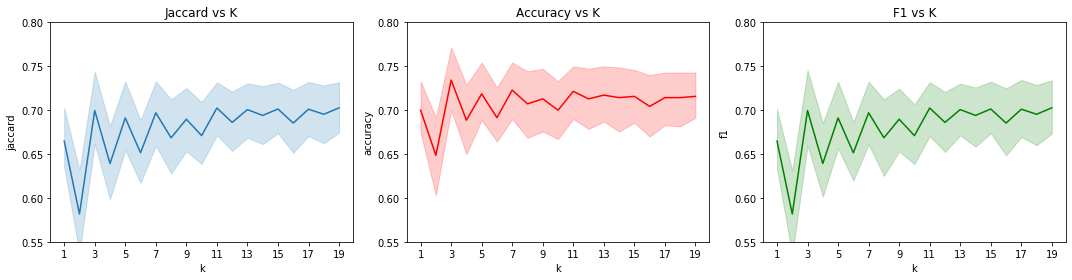

In [5]:
##Plot the Ks vs accuracy,jaccard,f1
fig,axes = plt.subplots(1,3,sharex=True,sharey=False,figsize=(15,4))
ax = axes.flatten()
ax[0].set_ylim(0.55,0.8)
sns.lineplot(data=plotting_df,x='k',y='jaccard',ax=ax[0],legend=False)
ax[0].set_title('Jaccard vs K')
sns.lineplot(data=plotting_df,x='k',y='accuracy',color='red',ax=ax[1],legend=False)
ax[0].set_xticks(range(1,31,2))
ax[1].set_title('Accuracy vs K')
ax[1].set_ylim(0.55,0.8)
sns.lineplot(data=plotting_df,x='k',y='f1',ax=ax[2],color='green')
ax[2].set_title('F1 vs K')
ax[2].set_ylim(0.55,0.8)
fig.tight_layout()

> Seems we have spike at k=3

### Run KNN on Testing data with optimized  K

> we can run k=3 on official testing data

Accuracy - 0.65 Jaccard - 0.62 F1 - 0.77
Confusion matrix, without normalization


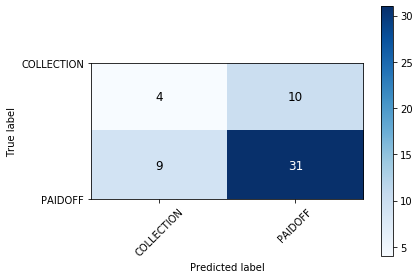

In [6]:
##Get training data without split
train_x = hot_encoding_df_train[feature_columns].to_numpy()
train_y = hot_encoding_df_train[dependent_feature].to_numpy()
train_x_normal = preprocessing.StandardScaler().fit_transform(train_x)

#Official testing dataframe from coursera
official_test_x = hot_encoding_df_test[feature_columns].to_numpy()
official_test_y = hot_encoding_df_test[dependent_feature].to_numpy()
official_test_x_normal = preprocessing.StandardScaler().fit_transform(official_test_x)

#encode binary of y
le = preprocessing.LabelEncoder()
train_y_binary = le.fit_transform(train_y)
official_test_y_binary = le.fit_transform(official_test_y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x_normal, train_y_binary)
y_hat_official_test = knn.predict(official_test_x_normal)
y_hat_train = knn.predict(train_x_normal)

##accuracy_score
knn_accuracy = accuracy_score(official_test_y_binary,y_hat_official_test)
knn_jacard = jaccard_score(official_test_y_binary,y_hat_official_test)
knn_f1_score = f1_score(official_test_y_binary,y_hat_official_test)
print("Accuracy - {:.2} Jaccard - {:.2} F1 - {:.2}".format(knn_accuracy, knn_jacard, knn_f1_score))



plot_confusion_matrix(confusion_matrix(official_test_y_binary,y_hat_official_test ),classes=np.unique(official_test_y))

# Decision Tree

## Decision Tree with Label Encoding

Accuracy - 0.76 Jaccard - 0.75 F1 - 0.86


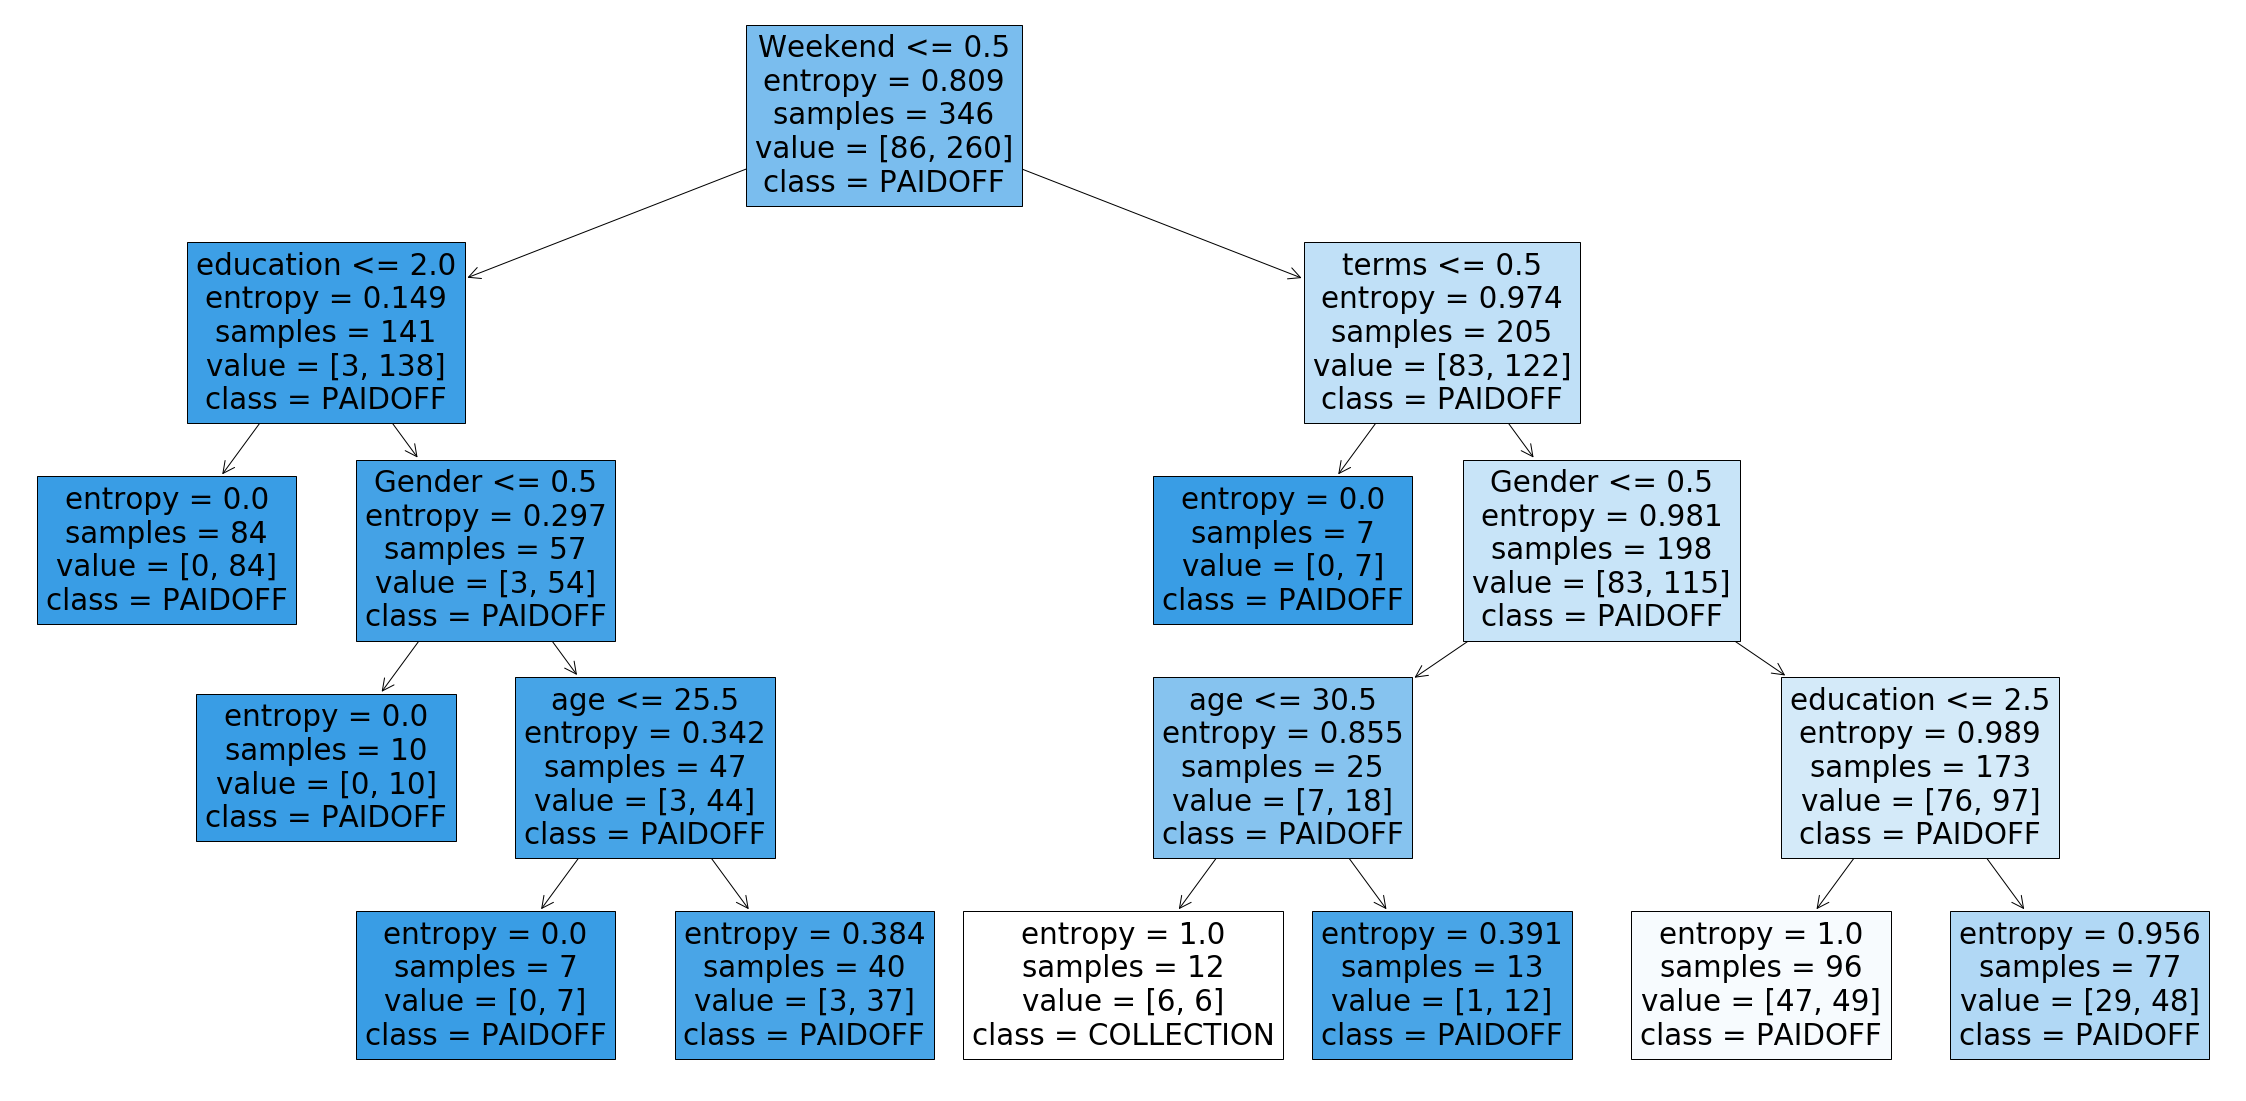

Confusion matrix, without normalization


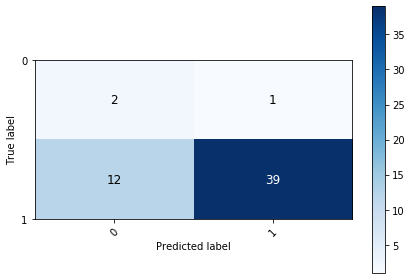

In [7]:
def get_label_encoding(url):
    '''get label encoding datasets from url provided by coursera'''

    #Read in dataset
    loan_df = pd.read_csv(url)

    #cast to datetime
    loan_df['due_date'] = pd.to_datetime(loan_df['due_date'])
    loan_df['effective_date'] = pd.to_datetime(loan_df['effective_date'])

    #Find out which day of week effecteive date was on
    loan_df['effective_date_dayofweek'] = loan_df['effective_date'].dt.day_name()

    loan_df['Weekend'] = 0
    loan_df.loc[loan_df['effective_date_dayofweek'].isin(['Friday','Saturday','Sunday']),'Weekend'] = 1

    loan_df = loan_df.drop(['Unnamed: 0','Unnamed: 0.1','effective_date','due_date','effective_date_dayofweek'],axis=1)

    #even principal and term are categorical
    labels = ['Principal','terms','education','Gender']
    for label in labels:
        lc = preprocessing.LabelEncoder()
        categories = np.unique(loan_df[label])
        lc.fit(categories)
        loan_df[label] = lc.transform(loan_df[label])
        
    return loan_df

#get both training and official datasets
encoded_train_df = get_label_encoding(train_csv_url)
encoded_test_df = get_label_encoding(test_csv_url)

#split into features and training,test ouput
encoded_train_df_x = encoded_train_df.drop('loan_status',axis=1)
encoded_test_df_x = encoded_test_df.drop('loan_status',axis=1)
encoded_train_df_y = encoded_train_df['loan_status']
encoded_test_df_y = encoded_test_df['loan_status']


#change Y data to binary so we can score it easy
le = preprocessing.LabelEncoder()
le.fit(encoded_train_df_y)
encoded_train_df_y_binary = le.transform(encoded_train_df_y)
encoded_test_df_y_binary = le.transform(encoded_test_df_y)

#Decision tree class works well with max detp
dt = tree.DecisionTreeClassifier(max_depth=4,criterion='entropy')
dt.fit(encoded_train_df_x,encoded_train_df_y_binary)
y_hat_test = dt.predict(encoded_test_df_x)

#score on encoded test
dt_acc = accuracy_score(y_hat_test, encoded_test_df_y_binary)
dt_jac = jaccard_score(y_hat_test, encoded_test_df_y_binary)
dt_f1 = f1_score(y_hat_test, encoded_test_df_y_binary)


print("Accuracy - {:.2f} Jaccard - {:.2} F1 - {:.2}".format(dt_acc, dt_jac, dt_f1))

#plot
fig, ax = plt.subplots(figsize=(40, 20))
tree.plot_tree(dt,ax=ax,feature_names=encoded_test_df_x.columns,class_names=np.unique(encoded_train_df_y),filled=True)
plt.show()
plot_confusion_matrix(confusion_matrix(y_hat_test,encoded_test_df_y_binary ),classes=np.unique(y_hat_test))

# Support Vector Machine

Accuracy - 0.78 Jaccard - 0.75 F1 - 0.86
Confusion matrix, without normalization


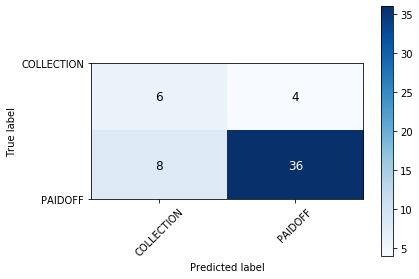

In [8]:
##Get training data without split
train_x = hot_encoding_df_train[feature_columns].to_numpy()
train_y = hot_encoding_df_train[dependent_feature].to_numpy()
train_x_normal = preprocessing.StandardScaler().fit_transform(train_x)

#Official testing dataframe from coursera
official_test_x = hot_encoding_df_test[feature_columns].to_numpy()
official_test_y = hot_encoding_df_test[dependent_feature].to_numpy()
official_test_x_normal = preprocessing.StandardScaler().fit_transform(official_test_x)

#encode binary of y
le = preprocessing.LabelEncoder()
train_y_binary = le.fit_transform(train_y)
official_test_y_binary = le.fit_transform(official_test_y)

'''I found that a 2nd degree polynomial fits better accuracy than rbc, most parameters overfit and get all PAIDOFF'''
kernel = 'poly'
degree = 2
gamma = 1
C = 1
svc = svm.SVC(kernel=kernel,degree=degree,gamma=gamma,C=C)
svc.fit(train_x_normal, train_y_binary) 

#Get y_hat_testing - will be in binary
y_hat_test = svc.predict(official_test_x_normal)


#Get metrics
svm_acc = accuracy_score(y_hat_test,official_test_y_binary)
svm_jaccard = jaccard_score(y_hat_test,official_test_y_binary)
svm_f1 = f1_score(y_hat_test,official_test_y_binary)

print("Accuracy - {:.2f} Jaccard - {:.2} F1 - {:.2}".format(svm_acc, svm_jaccard, svm_f1))
plot_confusion_matrix(confusion_matrix(y_hat_test,encoded_test_df_y_binary ),classes=np.unique(official_test_y))

# Logistic Regression

Accuracy - 0.80 Jaccard - 0.78 F1 - 0.88 Logloss - 0.69
Confusion matrix, without normalization
Weight of Principal is -0.00112
Weight of terms is -0.00150
Weight of age is 0.00041
Weight of Weekend is -0.00646
Weight of Gender_male is -0.00162
Weight of Gender_female is 0.00162
Weight of education_High School or Below is -0.00029
Weight of education_Bechalor is -0.00002
Weight of education_college is 0.00041
Weight of education_Master or Above is -0.00066


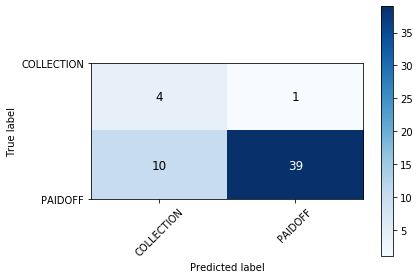

In [9]:
##Get training data without split
train_x = hot_encoding_df_train[feature_columns].to_numpy()
train_y = hot_encoding_df_train[dependent_feature].to_numpy()
train_x_normal = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(train_x)

train_x_normal = preprocessing.StandardScaler().fit_transform(train_x)

#Official testing dataframe from coursera
official_test_x = hot_encoding_df_test[feature_columns].to_numpy()
official_test_y = hot_encoding_df_test[dependent_feature].to_numpy()
official_test_x_normal = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(official_test_x)

official_test_x_normal = preprocessing.StandardScaler().fit_transform(official_test_x)


#encode binary of y
#For LR, the it has to have a (N,-1) shape for single feature
le = preprocessing.LabelEncoder()
train_y_binary = le.fit_transform(train_y).reshape((len(train_y),))
official_test_y_binary = le.fit_transform(official_test_y).reshape((len(official_test_y),))


'''Found a small C fits best'''
lr = LogisticRegression(C=0.0001,solver='liblinear',penalty = 'l2',random_state=0)
lr.fit(train_x_normal,train_y_binary)
y_hat_train = lr.predict(train_x_normal)
y_hat_test = lr.predict(official_test_x_normal)
y_hat_test_prob = lr.predict_proba(official_test_x_normal)

##Get LR metrics
lr_acc = accuracy_score(y_hat_test,official_test_y_binary)
lr_jaccard = jaccard_score(y_hat_test,official_test_y_binary)
lr_f1 = f1_score(y_hat_test,official_test_y_binary)
lr_loss = log_loss(y_hat_test, y_hat_test_prob)   
print("Accuracy - {:.2f} Jaccard - {:.2} F1 - {:.2} Logloss - {:.2}".format(lr_acc, lr_jaccard, lr_f1,lr_loss))
plot_confusion_matrix(confusion_matrix(y_hat_test,official_test_y_binary),classes=np.unique(official_test_y))

##Print out weights of each feature
for f,w in zip(feature_columns,lr.coef_[0]):
    print("Weight of {} is {:.5f}".format(f,w))

# Model Evaluation and Report using Test set

- Note all test set metrics were calculated in that section

In [10]:
pd.DataFrame([
    {i:k for i,k in zip(['Algorithm','Accuracy','Jaccard','F1-Score','LogLoss'],['KNN',knn_accuracy,knn_jacard,knn_f1_score,""])},
    {i:k for i,k in zip(['Algorithm','Accuracy','Jaccard','F1-Score','LogLoss'],['Decision Tree',dt_acc,dt_jac,dt_f1,""])},
    {i:k for i,k in zip(['Algorithm','Accuracy','Jaccard','F1-Score','LogLoss'],['SVM',svm_acc,svm_jaccard,svm_f1,""])},
    {i:k for i,k in zip(['Algorithm','Accuracy','Jaccard','F1-Score','LogLoss'],['Logistic Regression',lr_acc,lr_jaccard,lr_f1,lr_loss])}
])

,Algorithm,Accuracy,Jaccard,F1-Score,LogLoss
0,KNN,0.648148,0.62,0.765432,
1,Decision Tree,0.759259,0.75,0.857143,
2,SVM,0.777778,0.75,0.857143,
3,Logistic Regression,0.796296,0.78,0.876404,0.688805


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>